In [11]:
# | output: false
# Setup Notebook

path = "../../../../scripts/notebook_header.py"
import os


if os.path.basename(os.getcwd()) != "mtg-modeling":
    args = f"--path {path}"
    get_ipython().run_line_magic("run", f"-i {path} {args}")  # type: ignore

In [12]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

import src.plots.annotate as anno
import src.plots.symbols as symbols

In [13]:
set_code = "All_Sets"
set_codes_order = ["MKM", "OTJ", "MH3", "BLB"]

paths = {
    "processed": Path("data/processed/17lands/game_data/premier_draft"),
}
summary_file = paths["processed"] / f"{set_code}_Game_PD_Summary.parquet"
game_file = paths["processed"] / f"{set_code}_Game_PD_Games.parquet"
draft_file = paths["processed"] / f"{set_code}_Game_PD_Drafts.parquet"
card_file = paths["processed"] / f"{set_code}_Game_PD_Cards.parquet"

In [14]:
df_game = pl.scan_parquet(game_file)

# Introduction

This is a quick analysis to see the impact of being the first to play in a game has a distinct advantage.  In MTG, to balance the advantage of first to play, the first player forgoes drawing a card on their first turn.  This analysis will see if this effect is enough to balance out the advantage of going first.

This is a part of the MTG Arena draft analysis.  See the [Draft Introduction](00-intro.ipynb) for more information.  

# Starting Player

To assess the impact of going first or second, I plotted the win rates for each scenario. As shown in @fig-starting-win-rate, the win rate is significantly higher for the player who starts, with nearly a 7% advantage.  

This data is for 17Lands players, who have a high average win rate compared to the general MTG Arena population.

In [15]:
starting = (
    df_game.group_by(["on_play", "expansion"])
    .agg(
        pl.col("won").sum().alias("n_wins"),
        pl.col("won").count().alias("n_games"),
    )
    .with_columns(
        (pl.col("n_wins") / pl.col("n_games")).alias("win_rate"),
        (pl.col("n_games") / pl.col("n_games").sum()).alias("pct_games"),
    )
    .sort(by=["expansion", "on_play"], descending=[False, True])
)

mean_win_rate = starting.group_by("expansion").agg(
    pl.col("win_rate").mean().alias("mean_win_rate")
)

starting = (
    starting.join(mean_win_rate, on="expansion")
    .with_columns(
        (pl.col("win_rate") / pl.col("mean_win_rate") - 1).alias("normalized_win_rate")
    )
    .collect()
    .to_pandas()
)

starting["Player"] = starting["on_play"].map({False: "2nd Player", True: "1st Player"})

starting_only = starting[starting["on_play"] == 1]
starting_only = starting_only.merge(
    starting[starting["on_play"] == 0],
    on="expansion",
    suffixes=("_player1", "_player2"),
)
starting_only["win_rate_spread"] = (
    starting_only["win_rate_player1"] - starting_only["win_rate_player2"]
)

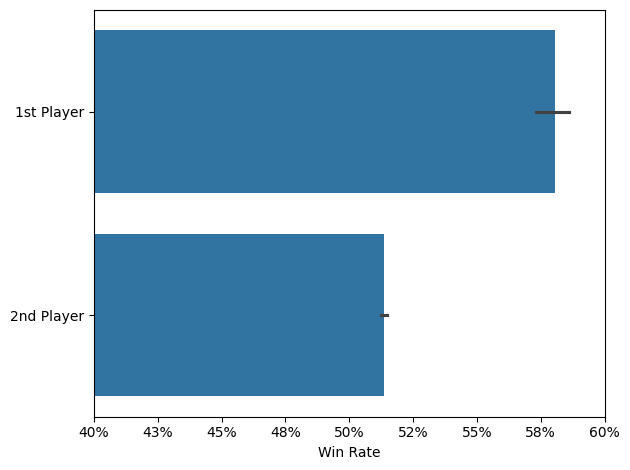

In [16]:
# | label: fig-starting-win-rate
# | fig-cap: "The win rate of 1st versus 2nd player."


g = sns.barplot(
    data=starting,
    x="win_rate",
    y="Player",
    order=["1st Player", "2nd Player"],
    orient="h",
)
plt.gca().set(xlim=(0.40, 0.60))
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(
    xlabel="Win Rate",
    ylabel="",
)

# Advantage per Set

To see if the advantage of going first is consistent across all sets, I plotted the win rate for first player for each draft set.  As shown in @fig-starting-set-win-rate, the advantage of going first does vary between sets, but the first player has a distinct advantage in all sets.

Note that 17Lands players have a high win rate 

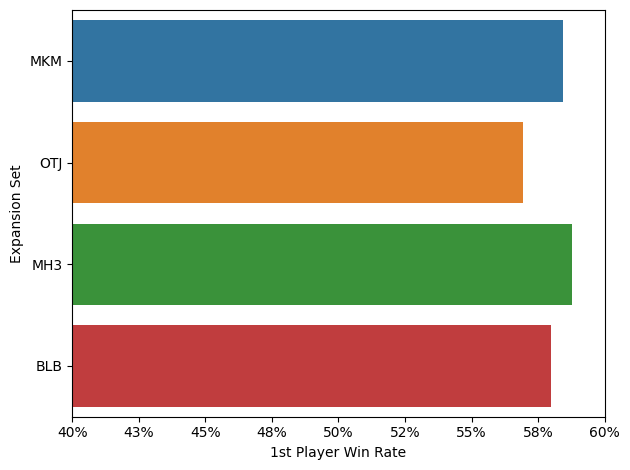

In [17]:
# | label: fig-starting-set-win-rate
# | fig-cap: "The win rate for the first player by set."


g = sns.barplot(
    data=starting_only,
    x="win_rate_player1",
    y="expansion",
    order=set_codes_order,
    hue="expansion",
    hue_order=set_codes_order,
    orient="h",
)
plt.gca().set(xlim=(0.40, 0.60))
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(
    xlabel="1st Player Win Rate",
    ylabel="Expansion Set",
)

# Spread of Win Rates

To account for the set differences in win rates for the 17Lands players, I plotted the spread of win rates for each set.  As shown in @fig-starting-set-win-rate-spread, the spread of win rates being 5.5% for OTJ and up to 7.5% for MH3.  

One reason MH3 may be more sensitive to the starting player is that the set has a faster play rate, with almost 1 turn less per game compared to the other sets analyzed.  See the [Game Length](22-turns.ipynb) analysis for more information.

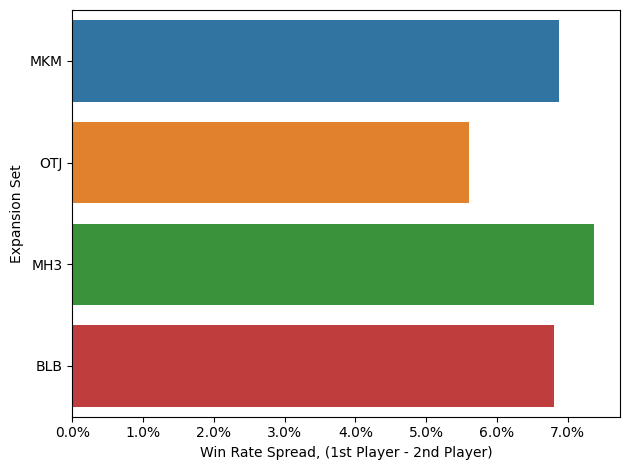

In [18]:
# | label: fig-starting-win-rate-spread
# | fig-cap: "Difference in win rates between first player and second player."


g = sns.barplot(
    data=starting_only,
    x="win_rate_spread",
    y="expansion",
    order=set_codes_order,
    hue="expansion",
    hue_order=set_codes_order,
    orient="h",
)
# plt.gca().set(xlim=(0.90, 1.10))
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(
    xlabel="Win Rate Spread, (1st Player - 2nd Player)",
    ylabel="Expansion Set",
)

In [19]:
# ADD Player Rank vs 1st Player Win Rate

In [20]:
# ADD Game Length vs 1st Player Win Rate

In [21]:
# ADD Temporal (Tempo) Analysis of Win Rate

# Conclusion

We have seen that the starting player has a distinct advantage in MTG Arena draft games.  This advantage is consistent across all sets analyzed, with the first player having a 5.5% to 7.5% advantage.  This disadvantage of not drawing a card on the first turn is not enough to balance out the advantage of going first.

Aspects affecting this advantage could be the rate of play, with short games having a higher advantage for the starting player.  This could be due to the first player being able to get ahead in tempo and maintain that advantage throughout the game.

Future analysis will look and player rank, game length, and tempo to see if these factors affect the advantage of going first.